In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd as ag
import higher  # Import the higher library for meta-learning

from sklearn.preprocessing import StandardScaler

import numpy as np 
import os
import sys
import copy
import matplotlib.pyplot as plt

import src.datamaker as datamaker
import src.training as training
import src.models as models

from tqdm import tqdm

from importlib import reload
reload(datamaker)
reload(training)
reload(models)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [16]:
def support_query_split(x_train, y_train, spt_frac):
    '''
    Split the data into support and query sets.

    Args:
    - x_train: the input data.
    - y_train: the target data.
    - spt_frac: the fraction of the data to use for the support set.

    Returns:
    - x_spt: the support input data.
    - y_spt: the support target data.
    - x_qry: the query input data.
    - y_qry: the query target data.
    '''
    n_spt = int(x_train.shape[1] * spt_frac)

    x_spt = np.empty((x_train.shape[0], n_spt, x_train.shape[2]))
    y_spt = np.empty((y_train.shape[0], n_spt, y_train.shape[2]))
    x_qry = np.empty((x_train.shape[0], x_train.shape[1] - n_spt, x_train.shape[2]))
    y_qry = np.empty((y_train.shape[0], y_train.shape[1] - n_spt, y_train.shape[2]))

    for i in range(x_train.shape[0]):
        x_spt[i] = x_train[i, :n_spt]
        y_spt[i] = y_train[i, :n_spt]
        x_qry[i] = x_train[i, n_spt:]
        y_qry[i] = y_train[i, n_spt:]

    return x_spt, y_spt, x_qry, y_qry

In [38]:
class MetaLearner(nn.Module):
    def __init__(self, model, update_lr, meta_lr, update_steps, loss_fn, seed=None, device=None):
        '''
        The meta-learner class.

        Args:
        - model: the model to be trained.
        - update_lr: the learning rate for the inner update.
        - meta_lr: the learning rate for the outer update.
        - update_steps: the number of inner update steps.
        '''
        super(MetaLearner, self).__init__()
        if seed is not None:
            torch.manual_seed(seed)

        self.rng = np.random.RandomState(seed)

        if device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        self.model = model.to(self.device)
        self.update_lr = update_lr
        self.meta_optim = optim.Adam(self.model.parameters(), lr=meta_lr)
        self.update_steps = update_steps
        self.loss_fn = loss_fn

        # Check for source of NaNs in gradients
        torch.autograd.set_detect_anomaly(True)

    def meta_train(self, x_spt, y_spt, x_qry, y_qry, batch_size=10):
        '''
        Perform the meta-training.

        Args:
        - x_spt: the support input data.
        - y_spt: the support target data.
        - x_qry: the query input data.
        - y_qry: the query target data.
        '''

        # Randomly sample tasks
        task_num = x_spt.size(0)
        batch_inds = self.rng.choice(task_num, size=batch_size, replace=False)
        meta_loss = 0
        for i in batch_inds:
            # # theta_i, clone the model parameters for task-specific updates
            fast_weights = [p.clone() for p in self.model.parameters()]

            # move the data to the device
            y_spt_task = y_spt[i].to(self.device)
            y_qry_task = y_qry[i].to(self.device)
            x_spt_task = x_spt[i].to(self.device)
            x_qry_task = x_qry[i].to(self.device)

            scaler_y = training.TorchStandardScaler()
            y_spt_scaled = scaler_y.fit_transform(y_spt_task)
            del y_spt_task
            y_qry_scaled = scaler_y.transform(y_qry_task)
            del y_qry_task

            scaler_x = training.TorchStandardScaler()
            x_spt_scaled = scaler_x.fit_transform(x_spt_task)
            del x_spt_task
            x_qry_scaled = scaler_x.transform(x_qry_task)
            del x_qry_task

            # inner update
            for _ in range(self.update_steps):
                y_pred = self.model(x_spt_scaled, params=fast_weights)
                loss = self.loss_fn(y_pred, y_spt_scaled)
                # compute gradient on theta_i
                try:
                    grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
                except Exception as e:
                    print('Caught exception:', e)
                    print('Cleaning up...')
                    del y_pred, y_spt_scaled, x_spt_scaled, y_qry_scaled, x_qry_scaled
                # update weights using Adam
                fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grads, fast_weights)))
            del y_pred, y_spt_scaled, x_spt_scaled

            # Evaluate the query loss
            y_pred_qry = self.model(x_qry_scaled, params=fast_weights)
            query_loss = self.loss_fn(y_pred_qry, y_qry_scaled)
            meta_loss += query_loss # Accumulate the query loss
            del y_pred_qry, y_qry_scaled, x_qry_scaled
            
        # Average the query loss
        meta_loss /= batch_size

        # Meta-optimization
        self.meta_optim.zero_grad()
        meta_loss.backward()
        self.meta_optim.step()

        return meta_loss.item()
    
    def adapt_and_predict(self, x_spt, y_spt, x_qry, update_steps=1):
        """
        Fine-tune the model on a new task using support set data (for evaluation).
        :param x_spt: Support set inputs.
        :param y_spt: Support set targets.
        :return: Fine-tuned model parameters.
        """
        # send the data to the device
        x_spt = x_spt.to(self.device)
        y_spt = y_spt.to(self.device)
        x_qry = x_qry.to(self.device)

        # # theta_i, clone the model parameters for task-specific updates
        fast_weights = [p.clone() for p in self.model.parameters()]

        scaler_y = training.TorchStandardScaler()
        y_spt_scaled = scaler_y.fit_transform(y_spt)

        scaler_x = training.TorchStandardScaler()
        x_spt_scaled = scaler_x.fit_transform(x_spt)
        x_qry_scaled = scaler_x.transform(x_qry)

        # inner update
        for _ in range(update_steps):
            y_pred = self.model(x_spt_scaled, params=fast_weights)
            loss = self.loss_fn(y_pred, y_spt_scaled)
            # compute gradient on theta_i
            grads = torch.autograd.grad(loss, fast_weights)
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grads, fast_weights)))

        # Predict on the query set with dropout
        y_pred_list = []
        for _ in range(100):
            y_pred = self.model(x_qry_scaled, params=fast_weights)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_pred_list.append(y_pred.detach().cpu().numpy())
        y_pred = np.mean(y_pred_list, axis=0)
        del y_pred_list

        return y_pred

In [32]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, params=None):
        """
        Forward pass through the model. Use `params` if provided for meta-updates.
        """
        if params is None:
            out = torch.relu(self.layer1(x))
            out = self.layer2(out)
        else:
            out = torch.relu(F.linear(x, params[0], params[1]))
            out = F.linear(out, params[2], params[3])
        return out

In [33]:
class CNN(nn.Module):
    def __init__(self, input_size=10, latent_dim=(16, 16), output_dim=750, dropout_rate=0.3):
        super(CNN, self).__init__()
        # Fully connected layers to map the input parameters to a 2D latent space
        self.fc1 = nn.Linear(input_size, latent_dim[0] * latent_dim[1])
        self.latent_dim = latent_dim
        # Convolutional layers with dilations and dropout
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=4, dilation=4)
        # Dropout layer after each convolutional layer
        self.dropout = nn.Dropout(dropout_rate)
        conv_output_dim = latent_dim[0]  # Keep output dimensions same due to padding
        self.fc2_input_size = 64 * conv_output_dim * conv_output_dim  # 64 channels from conv3
        self.fc2 = nn.Linear(self.fc2_input_size, output_dim)

    def forward(self, x, params=None):
        """
        Forward pass using fast weights if provided.
        :param x: Input tensor.
        :param params: Task-specific parameters (fast weights) for MAML.
        """
        if params is None:
            params = [p for p in self.parameters()]
        
        # Mapping fast weights for the layers
        fc1_weight, fc1_bias = params[0], params[1]
        conv1_weight, conv1_bias = params[2], params[3]
        conv2_weight, conv2_bias = params[4], params[5]
        conv3_weight, conv3_bias = params[6], params[7]
        fc2_weight, fc2_bias = params[8], params[9]

        # Step 1: Map input parameters to 2D latent space
        x = F.relu(F.linear(x, fc1_weight, fc1_bias))
        x = x.view(-1, 1, self.latent_dim[0], self.latent_dim[1])

        # Step 2: Pass through convolutional layers
        x = F.relu(F.conv2d(x, conv1_weight, conv1_bias, padding=1, dilation=1))
        x = self.dropout(x)
        x = F.relu(F.conv2d(x, conv2_weight, conv2_bias, padding=2, dilation=2))
        x = self.dropout(x)
        x = F.relu(F.conv2d(x, conv3_weight, conv3_bias, padding=4, dilation=4))
        x = self.dropout(x)

        # Step 3: Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, num_features)

        # Step 4: Fully connected output layer
        x = F.linear(x, fc2_weight, fc2_bias)

        return x

    def get_params(self):
        """
        Return a list of all learnable parameters in the network.
        This will be used to pass fast weights in MetaLearner.
        """
        return [p for p in self.parameters()]

(195, 2000, 10) (195, 2000, 750) (5, 2000, 10) (5, 2000, 750)
torch.Size([195, 1400, 10]) torch.Size([195, 1400, 750]) torch.Size([195, 600, 10]) torch.Size([195, 600, 750])
Epoch 1/390 - Loss: 1.0039
Epoch 2/390 - Loss: 1.0710
Epoch 3/390 - Loss: 0.6595
Epoch 4/390 - Loss: 0.6402
Epoch 5/390 - Loss: 0.8466
Epoch 6/390 - Loss: 0.4666
Epoch 7/390 - Loss: 0.5638
Epoch 8/390 - Loss: 0.3347
Epoch 9/390 - Loss: 0.5241
Epoch 10/390 - Loss: 0.5123
Epoch 11/390 - Loss: 0.2621
Epoch 12/390 - Loss: 0.1828
Epoch 13/390 - Loss: 0.3586
Epoch 14/390 - Loss: 0.1872
Epoch 15/390 - Loss: 0.1302
Epoch 16/390 - Loss: 0.1064
Epoch 17/390 - Loss: 0.1640
Epoch 18/390 - Loss: 0.1395
Epoch 19/390 - Loss: 0.1030
Epoch 20/390 - Loss: 0.2149
Epoch 21/390 - Loss: 0.0649
Epoch 22/390 - Loss: 0.0727
Epoch 23/390 - Loss: 0.1487
Epoch 24/390 - Loss: 0.0827
Epoch 25/390 - Loss: 0.0688
Epoch 26/390 - Loss: 0.0617
Epoch 27/390 - Loss: 0.0867
Epoch 28/390 - Loss: 0.0660
Epoch 29/390 - Loss: 0.1100
Epoch 30/390 - Loss: 0.

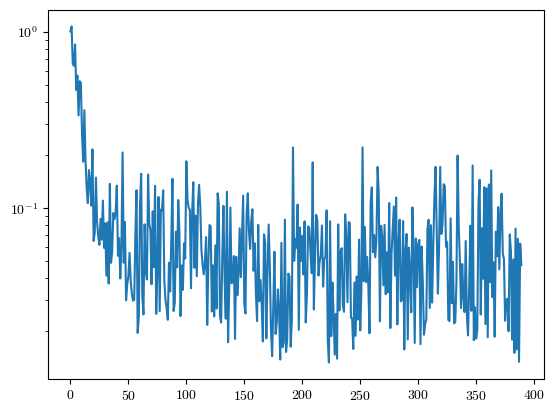

In [39]:
# load in the data
filename = 'data/200tasks_2000samples.npz'

if os.path.isfile(filename):
    with np.load(filename, allow_pickle=True) as data:
        X_train = data['X_train']
        y_train = data['y_train']

# Isolate 5 tasks for testing
all_inds = np.arange(X_train.shape[0])
test_inds = np.random.choice(X_train.shape[0], 5, replace=False)
train_inds = np.delete(all_inds, test_inds)

X_test = X_train[test_inds]
y_test = y_train[test_inds]
X_train = X_train[train_inds]
y_train = y_train[train_inds]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
# split the data into support and query sets
# shape (n_tasks, n_samples, n_features)
spt_frac = 0.7
x_spt, y_spt, x_qry, y_qry = support_query_split(X_train, y_train, spt_frac)

# convert to torch tensors
x_spt = torch.tensor(x_spt, dtype=torch.float32)
y_spt = torch.tensor(y_spt, dtype=torch.float32)
x_qry = torch.tensor(x_qry, dtype=torch.float32)
y_qry = torch.tensor(y_qry, dtype=torch.float32)
print(x_spt.size(), y_spt.size(), x_qry.size(), y_qry.size())

# take log of the target data and scale
y_spt = torch.log(y_spt)
y_qry = torch.log(y_qry)

#define the model

model = CNN(
    input_size=x_spt.size(-1),
    latent_dim=(16, 16),
    output_dim=y_spt.size(-1),
    dropout_rate=0.2
)
# model = SimpleModel(
#     input_size=x_spt.size(-1),
#     hidden_size=512,
#     output_size=y_spt.size(-1)
# )

# define the meta-learner
update_lr = 0.001
meta_lr = 0.01
update_steps = 10
loss_fn = nn.MSELoss()
meta_learner = MetaLearner(
    model,
    update_lr,
    meta_lr,
    update_steps,
    loss_fn,
    seed=14,
    device='cuda'
)

# train the model
n_epochs = 390
losses = []
for epoch in range(n_epochs):
    loss = meta_learner.meta_train(
        x_spt,
        y_spt,
        x_qry,
        y_qry,
        batch_size=1
    )
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f}')
    losses.append(loss)

# plot the loss
plt.figure()
plt.plot(losses)
plt.yscale('log')

Minimum MAPE: 12.775917388410601, Maximum MAPE: 195.54008034812006
Task 1 - Failure rate: 1.0
Minimum MAPE: 7.340278049683116, Maximum MAPE: 57.85051624879962
Task 2 - Failure rate: 1.0
Minimum MAPE: 12.203298720378006, Maximum MAPE: 59.62580563258907
Task 3 - Failure rate: 1.0
Minimum MAPE: 13.891555238483186, Maximum MAPE: 245.98788581804078
Task 4 - Failure rate: 1.0
Minimum MAPE: 4.196094782620097, Maximum MAPE: 71.0408329030442
Task 5 - Failure rate: 0.995


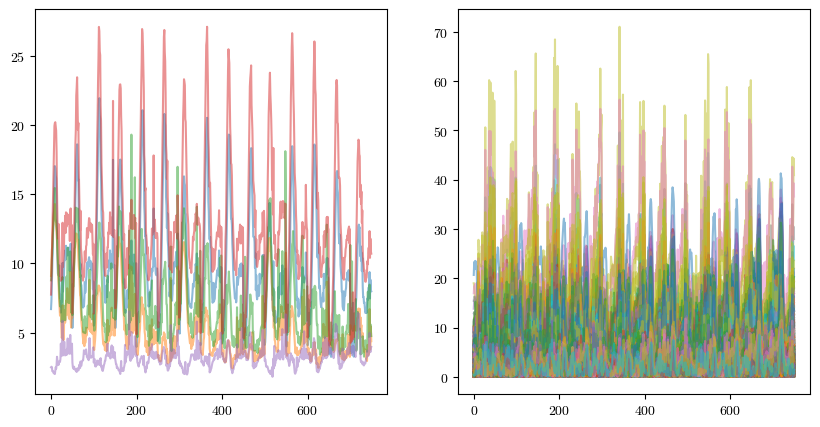

In [40]:
# Test the model
# split the data into support and query sets
spt_frac = 0.3
x_spt_test, y_spt_test, x_qry_test, y_qry_test = support_query_split(X_test, y_test, spt_frac)

# convert to torch tensors
x_spt_test = torch.tensor(x_spt_test, dtype=torch.float32)
y_spt_test = torch.tensor(y_spt_test, dtype=torch.float32)
x_qry_test = torch.tensor(x_qry_test, dtype=torch.float32)

# take log of y_spt_test
y_spt_test = torch.log(y_spt_test)

# fine-tune the model on the test tasks
fig, ax = plt.subplots(1,2, figsize=(10,5))
for i in range(x_spt_test.size(0)):
    y_pred = meta_learner.adapt_and_predict(
        x_spt_test[i],
        y_spt_test[i],
        x_qry_test[i],
        update_steps=512
    )
    y_pred = np.exp(y_pred)
    y_true = y_qry_test[i]

    ape = abs((y_pred - y_true) / y_true * 100)
    ell_mape = np.max(ape, axis=1)
    failure_rate = len(ell_mape[ell_mape>5]) / len(ape)
    print(f'Minimum MAPE: {np.min(ell_mape)}, Maximum MAPE: {np.max(ell_mape)}')
    print(f'Task {i+1} - Failure rate: {failure_rate}')
    sample_mape = np.mean(ape, axis=0)
    ax[0].plot(sample_mape, label=f'Task {i+1}', alpha=0.5)
ax[1].plot(ape.T, alpha=0.5);